# MODELING VIRAL SUCCESS: PREDICTING THE POPULARITY OF 5-MINUTE CRAFTS VIDEOS

### Topic:

Due to the wide variety of videos offered to us by different platforms, knowing why some videos succeed and others do not is challenging. Therefore, this project focuses on analyzing the **influence of the characteristics of the video titles of the YouTube channel '5-Minute Crafts' on the total number of views** they receive. In this way, through different Machine Learning models we can try to **predict the popularity of the videos** taking into account their titles.

### Information about 5-Minute Crafts:

5-Minute Crafts is a YouTube channel known for its Do It Yourself (DIY) style videos and is one of the most popular channels on the platform. Despite the channel's success, it has also been very controversial for proposing some dangerous tricks and also making heavy use of clickbait in their video titles. That is, they select sensationalist and misleading titles to get people's attention and generate more views.

In order to do my project, I will use the same dataset that I used for my EDA: https://www.kaggle.com/datasets/shivamb/5minute-crafts-video-views-dataset/data


# Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import joblib
from joblib import dump
import pickle
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

### Input data

In [3]:
five_minute_crafts = pd.read_csv('/Users/lunaflorestorres/Desktop/PREDICCION-DE-LA-POPULARIDAD-DE-LOS-VIDEOS-DE-5-MINUTE-CRAFTS/src/data/raw/5-Minute Crafts.csv')

In [4]:
five_minute_crafts.head()

,video_id,title,active_since_days,duration_seconds,total_views,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment
0,v=XHTofu5wbbM,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...,22,623,295614,60,12,2,4,0,2,5.000000,0,0,0.144444
1,v=HGxx0umIQvk,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...,1,739,130544,87,17,4,5,0,3,5.117647,0,0,0.086905
2,v=Tt4RMk3Ih04,HELPFUL LIFE HACKS FOR YOUR HOUSE,1,960,17834,33,6,0,6,0,2,5.500000,0,0,0.000000
3,v=A2MTydM5e58,USEFUL HACKS FOR YOUR HOME || Simple Tips That...,30,833,3128867,66,12,2,5,0,3,5.500000,0,0,0.058333
4,v=_halJ4yrmGQ,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...,15,3600,4210362,56,10,1,5,0,4,5.600000,0,0,0.500000


# Exploratory data analysis (EDA)

### Explanatory notes for some columns:

* Active_since_days: active video since x days
* Num_chars: total characters in the title of the video
* Num_words: total number of words in the video title
* Num_punctuation: number of punctuation marks
* Num_words_uppercase: number of words in capital letters
Num_words_lowercase: number of words in lowercase * Num_words_lowercase: number of lowercase words
* Num_stopwords: "empty words" are words that are used in information retrieval and natural language processing because they do not provide a specific meaning and do not help to distinguish a particular document or text fragment. These words are usually prepositions, conjunctions, articles and other terms very frequent in a language. E.g.: the, and,is,in,of,of....
* Avg_word_len: average length of the word
* Contain_digits: the title contains digits
* Startswith_digits: if the title starts with a digit
* Title_sentiment: sentiment of the video title.  It means how positive or negative the title is. It is calculated with the python textblob library.

In [5]:
five_minute_crafts.dtypes

video_id                object
title                   object
active_since_days        int64
duration_seconds         int64
total_views              int64
num_chars                int64
num_words                int64
num_punctuation          int64
num_words_uppercase      int64
num_words_lowercase      int64
num_stopwords            int64
avg_word_len           float64
contain_digits           int64
startswith_digits        int64
title_sentiment        float64
dtype: object

In [6]:
five_minute_crafts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4978 entries, 0 to 4977
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   video_id             4978 non-null   object 
 1   title                4978 non-null   object 
 2   active_since_days    4978 non-null   int64  
 3   duration_seconds     4978 non-null   int64  
 4   total_views          4978 non-null   int64  
 5   num_chars            4978 non-null   int64  
 6   num_words            4978 non-null   int64  
 7   num_punctuation      4978 non-null   int64  
 8   num_words_uppercase  4978 non-null   int64  
 9   num_words_lowercase  4978 non-null   int64  
 10  num_stopwords        4978 non-null   int64  
 11  avg_word_len         4978 non-null   float64
 12  contain_digits       4978 non-null   int64  
 13  startswith_digits    4978 non-null   int64  
 14  title_sentiment      4978 non-null   float64
dtypes: float64(2), int64(11), object(2)
me

In [7]:
five_minute_crafts.describe()

,active_since_days,duration_seconds,total_views,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment
count,4978.000000,4978.000000,4.978000e+03,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000
mean,827.808759,932.421655,4.349619e+06,44.456408,8.208718,0.495982,6.138610,0.287264,2.050020,5.463782,0.913821,0.856770,0.225993
std,426.975866,727.392576,9.936944e+06,13.470281,2.516098,0.901010,2.546744,1.355098,1.373312,0.662885,0.280657,0.350343,0.377586
min,1.000000,11.000000,4.034000e+03,11.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.666667,0.000000,0.000000,-1.000000
25%,365.000000,696.000000,5.679352e+05,35.000000,6.000000,0.000000,5.000000,0.000000,1.000000,5.000000,1.000000,1.000000,0.000000
50%,730.000000,867.000000,1.459397e+06,43.000000,8.000000,0.000000,6.000000,0.000000,2.000000,5.375000,1.000000,1.000000,0.200000
75%,1095.000000,960.000000,4.271779e+06,52.000000,10.000000,1.000000,8.000000,0.000000,3.000000,5.800000,1.000000,1.000000,0.450000
max,1460.000000,14880.000000,2.830311e+08,100.000000,20.000000,6.000000,18.000000,12.000000,9.000000,10.000000,1.000000,1.000000,1.000000


In [8]:
five_minute_crafts.shape

(4978, 15)

In [9]:
five_minute_crafts.columns

Index(['video_id', 'title', 'active_since_days', 'duration_seconds',
       'total_views', 'num_chars', 'num_words', 'num_punctuation',
       'num_words_uppercase', 'num_words_lowercase', 'num_stopwords',
       'avg_word_len', 'contain_digits', 'startswith_digits',
       'title_sentiment'],
      dtype='object')

### Cleaning

In [10]:
five_minute_crafts.nunique()

video_id               4978
title                  4965
active_since_days        31
duration_seconds        663
total_views            4978
num_chars                87
num_words                18
num_punctuation           7
num_words_uppercase      17
num_words_lowercase      13
num_stopwords            10
avg_word_len            254
contain_digits            2
startswith_digits         2
title_sentiment         339
dtype: int64

In [11]:
nulls = five_minute_crafts.isnull().sum()
nulls

video_id               0
title                  0
active_since_days      0
duration_seconds       0
total_views            0
num_chars              0
num_words              0
num_punctuation        0
num_words_uppercase    0
num_words_lowercase    0
num_stopwords          0
avg_word_len           0
contain_digits         0
startswith_digits      0
title_sentiment        0
dtype: int64

In [12]:
duplicated = five_minute_crafts.duplicated()
total_duplicated = duplicated.sum()
total_duplicated

0

### Replace ' l ' with ' | ' and re-count lowercase letters

In [13]:
five_minute_crafts['title'] = five_minute_crafts['title'].replace(' l ', ' | ')

In [14]:
def contar_minusculas(texto):
    return sum(1 for palabra in texto.split() if palabra[0].islower())

In [15]:
five_minute_crafts['num_words_lowercase'] = five_minute_crafts['title'].apply(contar_minusculas)

In [16]:
five_minute_crafts.to_csv('clean_five_minute_crafts.csv',index=False)

### Correlation study

My project started with a simple but ambitious idea: that was to find out if it is possible to predict which YouTube videos are going to be a hit before they are even published. The starting point was my exploratory data analysis, based on the titles of videos on the YouTube channel 5 Minute Crafts. I was looking for a connection between the title and the views.

In today's digital age, video content has become one of the most influential tools for communication and entertainment, so having the ability to predict which videos will be popular before they are released is very useful for content creators, marketing strategies and even for the distribution platforms themselves.

First, I wanted to implement supervised linear regression models in order to predict the total_views, which would be my target variable. 


In [17]:
five_minute_crafts = pd.read_csv('/Users/lunaflorestorres/Desktop/PREDICCION-DE-LA-POPULARIDAD-DE-LOS-VIDEOS-DE-5-MINUTE-CRAFTS/src/data/processed/clean_five_minute_crafts.csv')

<Axes: >

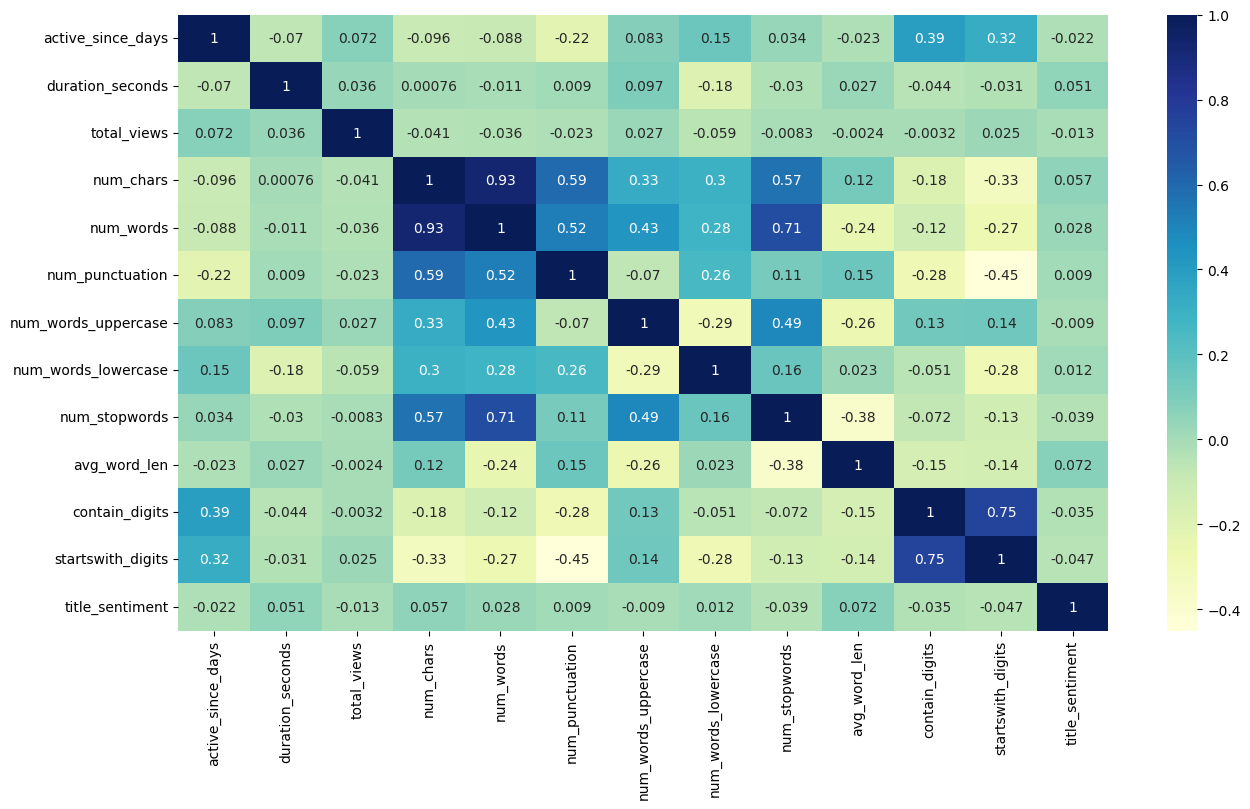

In [18]:
corr = five_minute_crafts.drop(['video_id', 'title'], axis=1).corr()

plt.figure(figsize=(15, 8))
sb.heatmap(corr, annot=True, cmap='YlGnBu')

However, when I studied the correlation between the variables, I realized that it was too low. Therefore, I thought it would be best to create new variables. In this case, I used a method I already used in the EDA that identified the 5 most popular words in the titles or the most repeated ones. After transforming them into numerical ones using get dummies, I was able to train my data with different regression models.

Since the correlation with target is very low ('total_views') I need to find more variables. To do this, I'm going to use a method I already used in the EDA that detected the most popular/repeated words in the titles:

In [19]:
# Tokenize titles using split() and count the frequency of each word:
# split(): split a string into a list of substrings.
# If you don't use expand=True, it would return a list series instead of a df where each word in a title occupies a different column.
# stack(): stacks the columns of the df into a single column so that they can be summed.
frecuencia_de_palabra= five_minute_crafts['title'].str.split(expand=True).stack().value_counts()

# Obtain the 20 most common words
top_20_words = frecuencia_de_palabra.head(20)

# Print the 20 most common words
print(top_20_words)

HACKS     2204
TO        1170
YOU        961
YOUR       862
AND        849
LIFE       791
FOR        745
THAT       629
||         552
IDEAS      528
25         426
DIY        424
CRAFTS     409
TRICKS     372
MAKE       369
WILL       359
EASY       325
20         324
COOL       286
30         280
Name: count, dtype: int64


I am going to use the 5 most popular/repeated words in the titles because, having tested different numbers of words, these 5 work best with the model.

In [20]:
most_popular_words = ['hacks', 'life', 'ideas','DIY', 'crafts']

# Create a column
five_minute_crafts['most_popular_words'] = five_minute_crafts['title'].str.lower()

dummies = pd.get_dummies(five_minute_crafts['most_popular_words'].apply(lambda x: pd.Series([1 if palabra in x else 0 for palabra in most_popular_words], index=most_popular_words)))
five_minute_crafts = pd.concat([five_minute_crafts, dummies], axis=1)

# Remove the column 'most_popular_words'.
five_minute_crafts.drop('most_popular_words', axis=1, inplace=True)


five_minute_crafts.head()


,video_id,title,active_since_days,duration_seconds,total_views,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment,hacks,life,ideas,DIY,crafts
0,v=XHTofu5wbbM,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...,22,623,295614,60,12,2,4,0,2,5.000000,0,0,0.144444,1,1,0,0,0
1,v=HGxx0umIQvk,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...,1,739,130544,87,17,4,5,0,3,5.117647,0,0,0.086905,1,0,1,0,0
2,v=Tt4RMk3Ih04,HELPFUL LIFE HACKS FOR YOUR HOUSE,1,960,17834,33,6,0,6,0,2,5.500000,0,0,0.000000,1,1,0,0,0
3,v=A2MTydM5e58,USEFUL HACKS FOR YOUR HOME || Simple Tips That...,30,833,3128867,66,12,2,5,0,3,5.500000,0,0,0.058333,1,0,0,0,0
4,v=_halJ4yrmGQ,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...,15,3600,4210362,56,10,1,5,0,4,5.600000,0,0,0.500000,1,0,0,0,1


# Supervised learning

I begin by testing some supervised regression models:

#### Split data

In [21]:
X = five_minute_crafts.drop(['video_id', 'title', 'total_views'], axis=1)
y = five_minute_crafts['total_views']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Scaling the data

In [22]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Testing models

In [23]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net": ElasticNet(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "XGBoost Regressor": XGBRegressor(),
    "SVR": SVR()
}

#### Training models

In [24]:
for name, model in models.items():
    print(f"Model: {name}")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    print("RMSE:", rmse)

    mae = mean_absolute_error(y_test, y_pred)
    print("MAE:", mae)

    r2 = r2_score(y_test, y_pred)
    print("R²:", r2)

    try:
        mape = mean_absolute_percentage_error(y_test, y_pred)
        print("MAPE:", mape)
    except ValueError:
        print("MAPE: Not calculable (may contain zeros in the test set)")

    try:
        msle = mean_squared_log_error(y_test, y_pred)
        print("MSLE:", msle)
    except ValueError:
        print("MSLE: Not calculable (may contain negative predictions)")

    print("-" * 40)

Model: Linear Regression
MSE: 146455225086340.75
RMSE: 12101868.660927566
MAE: 4805241.741330234
R²: 0.019775614836083144
MAPE: 6.755044638446356
MSLE: 2.9972365138885237
----------------------------------------
Model: Ridge Regression
MSE: 146439766796705.94
RMSE: 12101229.970408212
MAE: 4803857.054804936
R²: 0.019879077122553657
MAPE: 6.757480139957096
MSLE: 2.997465539455025
----------------------------------------
Model: Lasso Regression
MSE: 146455204491922.28
RMSE: 12101867.810049914
MAE: 4805239.933570009
R²: 0.01977575267446463
MAPE: 6.755051814714295
MSLE: 2.997237722446156
----------------------------------------
Model: Elastic Net
MSE: 146980218966407.1
RMSE: 12123539.869460862
MAE: 4803609.337525326
R²: 0.016261832360930928
MAPE: 7.503685997272094
MSLE: 3.0919105286639503
----------------------------------------
Model: Random Forest Regressor


/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.022e+15, tolerance: 3.425e+13
  model = cd_fast.enet_coordinate_descent(


MSE: 154629705225970.22
RMSE: 12435019.309432946
MAE: 5061694.327541906
R²: -0.03493615638395409
MAPE: 4.76712881078738
MSLE: 2.525940611925484
----------------------------------------
Model: Gradient Boosting Regressor


MSE: 147336350163261.0
RMSE: 12138218.574538069
MAE: 4631781.577944531
R²: 0.013878247321421289
MAPE: 5.712719377541341
MSLE: Not calculable (may contain negative predictions)
----------------------------------------
Model: XGBoost Regressor
MSE: 182945230360874.38
RMSE: 13525724.762868509
MAE: 5450851.070745874
R²: -0.22445188175047437
MAPE: 5.798117419187573
MSLE: Not calculable (may contain negative predictions)
----------------------------------------
Model: SVR
MSE: 159544951247406.38
RMSE: 12631110.451872645
MAE: 4057840.4210295724
R²: -0.06783388336126905
MAPE: 3.0787937742178224
MSLE: 2.2195722672968543
----------------------------------------


* MSE (Mean Squared Error): A lower value indicates a better fit. It strongly penalizes large errors.
* RMSE (Root Mean Squared Error): Similar to MSE, but in the original units of the target variable. A lower value also indicates a better fit.
* MAE (Mean Absolute Error): Provides the magnitude of the error. A lower value means a better fit.
* R² (R-squared): Indicates the proportion of the variance of the dependent variable that is predictable from the independent variables. Closer to 1 is better.
* MAPE (Mean Absolute Percentage Error): A lower value indicates a better fit.
* MSLE (Mean Squared Logarithmic Error): A lower value indicates a better fit.

#### Improve the model

At the moment, the best model is Ridge Regression:

* MSE: 146439766796705.94
* RMSE: 12101229.970408212
* MAE: 4803857.054804936
* R²: 0.019879077122553657
* MAPE: 6.757480139957096
* MSLE: 2.997465539455025

I will try to improve it using 'grid_search' and 'cross validation':

In [25]:
rr = Ridge()
param_grid = {
    'alpha': [0.1,0.5,1.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
}


scorer = make_scorer(mean_squared_error, greater_is_better=False)
grid_search = GridSearchCV(estimator=rr, param_grid=param_grid, scoring=scorer, cv=5)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best parameters:", best_params)

Best parameters: {'alpha': 1.0, 'solver': 'saga'}


In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

ridge_model_best = Ridge(alpha=1.0, solver='lsqr')

cv_scores = cross_val_score(ridge_model_best, X_train, y_train, cv=5, scoring='neg_mean_squared_error')


cv_scores = -cv_scores

print("Cross-validation score:", cv_scores)
print("Average MSE:", cv_scores.mean())

Cross-validation score: [8.42134586e+13 6.95797152e+13 7.95901157e+13 1.02006345e+14
 9.15739704e+13]
Average MSE: 85392720957393.98


Comparing the results, we observe that the **Mean Squared Error** after applying 'grid_search' and 'cross validation' is lower, indicating improved performance in terms of fit to the data. However, the resulting figure is extremely high, suggesting that **the model is making very large quadratic errors in its predictions**.

To improve this, I am going to use **unsupervised modeling** tools and then re-test the model. I have used clustering, where I grouped the videos into 6 groups with similar characteristics using the K-Means, I retrained the model.

#### Clustering

In [27]:
# Select the features to use for clustering. 

features_for_clustering = ['duration_seconds', 'num_chars', 'num_words',
                           'num_punctuation', 'num_words_uppercase',
                           'num_words_lowercase', 'num_stopwords',
                           'avg_word_len', 'contain_digits',
                           'startswith_digits', 'title_sentiment',
                           'hacks','life','ideas','DIY','crafts']

X_clustering = five_minute_crafts[features_for_clustering]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

In [28]:
# Standardize the characteristics

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

five_minute_crafts['cluster_label'] = clusters
five_minute_crafts.head()

,video_id,title,active_since_days,duration_seconds,total_views,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,...,avg_word_len,contain_digits,startswith_digits,title_sentiment,hacks,life,ideas,DIY,crafts,cluster_label
0,v=XHTofu5wbbM,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...,22,623,295614,60,12,2,4,0,...,5.000000,0,0,0.144444,1,1,0,0,0,2
1,v=HGxx0umIQvk,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...,1,739,130544,87,17,4,5,0,...,5.117647,0,0,0.086905,1,0,1,0,0,1
2,v=Tt4RMk3Ih04,HELPFUL LIFE HACKS FOR YOUR HOUSE,1,960,17834,33,6,0,6,0,...,5.500000,0,0,0.000000,1,1,0,0,0,2
3,v=A2MTydM5e58,USEFUL HACKS FOR YOUR HOME || Simple Tips That...,30,833,3128867,66,12,2,5,0,...,5.500000,0,0,0.058333,1,0,0,0,0,2
4,v=_halJ4yrmGQ,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...,15,3600,4210362,56,10,1,5,0,...,5.600000,0,0,0.500000,1,0,0,0,1,0


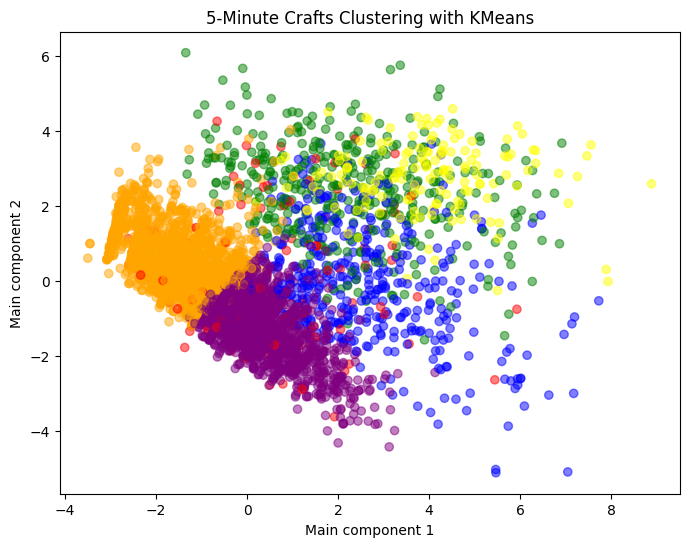

In [29]:
# Group the videos in 6 groups with similar characteristics.

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']
cluster_colors = [colors[label] for label in clusters]

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_colors, alpha=0.5)
plt.title('5-Minute Crafts Clustering with KMeans')
plt.xlabel('Main component 1')
plt.ylabel('Main component 2')
plt.show()

There appears to be some clustering, albeit with some points of overlap between clusters. This could mean that, although there are distinctive patterns separating the groups, there are also features in common between some videos from different clusters.

Descriptive statistics of 'total_views' per cluster:
                 count          mean           std      min         25%  \
cluster_label                                                            
0               119.0  5.333862e+06  7.107037e+06  90733.0  1231163.00   
1               399.0  3.295321e+06  5.433566e+06   5648.0   501726.50   
2               396.0  4.469012e+06  1.445616e+07  17834.0   427179.25   
3              2005.0  4.303945e+06  8.912902e+06  52001.0   631561.00   
4              1906.0  4.806498e+06  1.082126e+07  53592.0   642931.75   
5               153.0  9.314987e+05  6.365456e+06   4034.0    33760.00   

                     50%         75%          max  
cluster_label                                      
0              2803447.0  6120722.50   42004897.0  
1              1322384.0  3620142.00   46634625.0  
2               967762.5  2783322.25  199331430.0  
3              1582130.0  4378375.00  178057735.0  
4              1548324.5  5110676.75  283

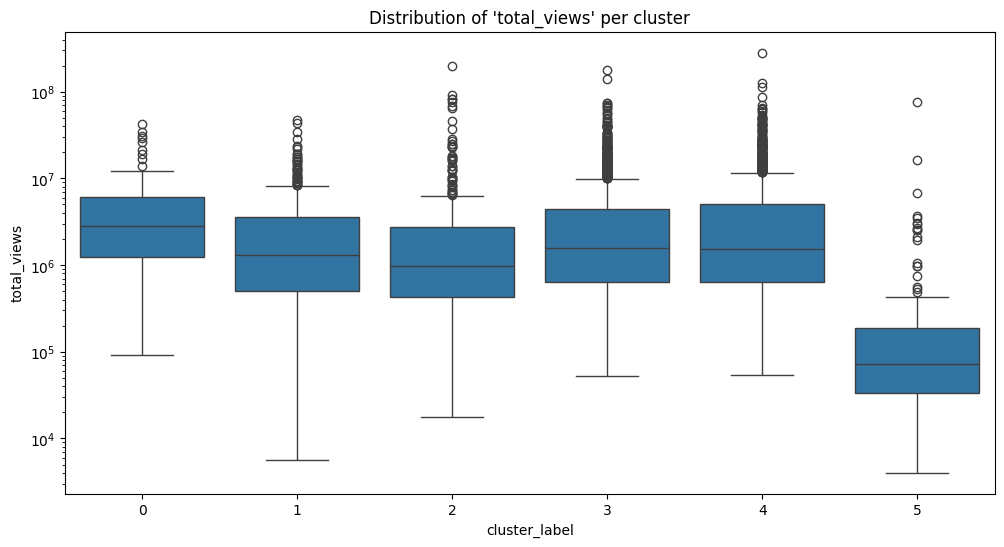

In [30]:
cluster_descriptive_stats = five_minute_crafts.groupby('cluster_label')['total_views'].describe()

cluster_mean_median = five_minute_crafts.groupby('cluster_label')['total_views'].agg(['mean', 'median'])

print("Descriptive statistics of 'total_views' per cluster:\n", cluster_descriptive_stats)
print("\nMean and median 'total_views' per cluster:\n", cluster_mean_median)


import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster_label', y='total_views', data=five_minute_crafts)
plt.title("Distribution of 'total_views' per cluster")
plt.yscale('log')  # best visualization
plt.show()

There is variability in video popularity, which is being captured by the clustering model. 

In [31]:
five_minute_crafts.to_csv('clustering_five_minute_crafts.csv',index=False)

In [32]:
five_minute_crafts = pd.read_csv(filepath_or_buffer="clustering_five_minute_crafts.csv")

### Add these new features to see if this improves the model:

In [33]:
cluster_dummies = pd.get_dummies(five_minute_crafts['cluster_label'], prefix='cluster')

five_minute_crafts_with_dummies = pd.concat([five_minute_crafts, cluster_dummies], axis=1)

five_minute_crafts_with_dummies['duration_cluster_interaction'] = five_minute_crafts_with_dummies['duration_seconds'] * five_minute_crafts_with_dummies['cluster_label']

print(five_minute_crafts_with_dummies[['duration_seconds', 'cluster_label', 'duration_cluster_interaction']].head())

   duration_seconds  cluster_label  duration_cluster_interaction
0               623              2                          1246
1               739              1                           739
2               960              2                          1920
3               833              2                          1666
4              3600              0                             0


In [34]:
five_minute_crafts['duration_cluster_interaction'] = five_minute_crafts['duration_seconds'] * five_minute_crafts['cluster_label']

I check the models again after this process to see if they have improved or not:

In [35]:
X = five_minute_crafts.drop(['total_views', 'video_id', 'title', 'cluster_label'], axis=1)
y = five_minute_crafts['total_views']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net": ElasticNet(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "XGBoost Regressor": XGBRegressor(),
    "SVR": SVR()
}

In [38]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Model: {name}")
    print(f"RMSE: {rmse}")
    print(f"R^2: {r2}")
    print("-" * 40)

Model: Linear Regression
RMSE: 12084383.513877237
R^2: 0.02260608445323886
----------------------------------------
Model: Ridge Regression
RMSE: 12083753.429766167
R^2: 0.02270800513800808
----------------------------------------
Model: Lasso Regression
RMSE: 12084382.668211818
R^2: 0.022606221249328873
----------------------------------------
Model: Elastic Net
RMSE: 12109950.814493708
R^2: 0.018465904795714083
----------------------------------------


/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.155e+15, tolerance: 3.425e+13
  model = cd_fast.enet_coordinate_descent(


Model: Random Forest Regressor
RMSE: 12451878.665426096
R^2: -0.037744384480292936
----------------------------------------
Model: Gradient Boosting Regressor
RMSE: 12173792.192819683
R^2: 0.008089700483814855
----------------------------------------
Model: XGBoost Regressor
RMSE: 13326006.3211964
R^2: -0.18855877177755676
----------------------------------------
Model: SVR
RMSE: 12631110.644474214
R^2: -0.06783391592633659
----------------------------------------


The result was quite low because I obtained a coefficient of determination of 2.2% (0.022). That is, **the model was not capturing the relationship between the variables well**.

-----

# Classification by ranks

After seeing this result, I realized that perhaps the best option was to change the focus of the project. I would no longer try to predict the visualizations of the videos, but I would make a classification in 5 groups.

In this way, I would try to create a model that would predict which group each video belongs to, according to the characteristics of the title, and therefore the range in which the number of views would move approximately. That is, I divided the total number of views into 5 groups, creating ranges of views (popular_encoded). This would now be my target variable.

In [39]:
five_minute_crafts = pd.read_csv('/Users/lunaflorestorres/Desktop/PREDICCION-DE-LA-POPULARIDAD-DE-LOS-VIDEOS-DE-5-MINUTE-CRAFTS/src/data/processed/clean_five_minute_crafts.csv')

In [40]:
five_minute_crafts.head()

,video_id,title,active_since_days,duration_seconds,total_views,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment
0,v=XHTofu5wbbM,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...,22,623,295614,60,12,2,4,0,2,5.000000,0,0,0.144444
1,v=HGxx0umIQvk,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...,1,739,130544,87,17,4,5,0,3,5.117647,0,0,0.086905
2,v=Tt4RMk3Ih04,HELPFUL LIFE HACKS FOR YOUR HOUSE,1,960,17834,33,6,0,6,0,2,5.500000,0,0,0.000000
3,v=A2MTydM5e58,USEFUL HACKS FOR YOUR HOME || Simple Tips That...,30,833,3128867,66,12,2,5,0,3,5.500000,0,0,0.058333
4,v=_halJ4yrmGQ,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...,15,3600,4210362,56,10,1,5,0,4,5.600000,0,0,0.500000


In [41]:
five_minute_crafts['total_views'].describe()

count    4.978000e+03
mean     4.349619e+06
std      9.936944e+06
min      4.034000e+03
25%      5.679352e+05
50%      1.459397e+06
75%      4.271779e+06
max      2.830311e+08
Name: total_views, dtype: float64

* Very bad video: Less than 10,000 views.
* Bad video: 10,000 - 100,000 views.
* Normal video: 100,000 - 1,000,000 views.
* Good video: 1,000,000 - 10,000,000 views.
* Super video: More than 10,000,000 views.

In [42]:
# Define visit ranges
ranges = [0, 10000, 100000, 1000000, 10000000, float('inf')]
labels = ["very bad video", "bad video", "normal", "good video", "super video"]

# Sort the data according to the ranges
five_minute_crafts['popularity_group'] = pd.cut(five_minute_crafts['total_views'], bins=ranges, labels=labels)

five_minute_crafts.drop('total_views', axis=1, inplace=True)

five_minute_crafts.to_csv('videos_classified.csv', index=False)


In [43]:
five_minute_crafts = pd.read_csv('/Users/lunaflorestorres/Desktop/PREDICCION-DE-LA-POPULARIDAD-DE-LOS-VIDEOS-DE-5-MINUTE-CRAFTS/src/data/processed/videos_classified.csv')

In [44]:
# Print an example of the first title of each popularity rank
for label in labels:
    example_title = five_minute_crafts[five_minute_crafts['popularity_group'] == label]['title'].iloc[0]
    print(f"Rank: {label} - Title {example_title}")

Rank: very bad video - Title How to use an electric wire for a cool light decoration l 5-MINUTE CRAFTS
Rank: bad video - Title HELPFUL LIFE HACKS FOR YOUR HOUSE
Rank: normal - Title SUPER LAZY LIFE HACKS || Cool Hacks To Make Your Life Easier
Rank: good video - Title USEFUL HACKS FOR YOUR HOME || Simple Tips That Work Extremely Well
Rank: super video - Title BRILLIANT LIFE HACKS FOR ANY SITUATION


In [45]:
five_minute_crafts.head()

,video_id,title,active_since_days,duration_seconds,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment,popularity_group
0,v=XHTofu5wbbM,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...,22,623,60,12,2,4,0,2,5.000000,0,0,0.144444,normal
1,v=HGxx0umIQvk,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...,1,739,87,17,4,5,0,3,5.117647,0,0,0.086905,normal
2,v=Tt4RMk3Ih04,HELPFUL LIFE HACKS FOR YOUR HOUSE,1,960,33,6,0,6,0,2,5.500000,0,0,0.000000,bad video
3,v=A2MTydM5e58,USEFUL HACKS FOR YOUR HOME || Simple Tips That...,30,833,66,12,2,5,0,3,5.500000,0,0,0.058333,good video
4,v=_halJ4yrmGQ,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...,15,3600,56,10,1,5,0,4,5.600000,0,0,0.500000,good video


In [46]:
custom_mapping = {'bad video': 1, 'good video': 3, 'normal': 2, 'super video': 4, 'very bad video': 0}

label_encoder = LabelEncoder()
label_encoder.fit(list(custom_mapping.keys()))

# Apply mapping and encode in numbers
five_minute_crafts['popularity_encoded'] = five_minute_crafts['popularity_group'].map(custom_mapping)

print(five_minute_crafts[['popularity_group', 'popularity_encoded']].head())


  popularity_group  popularity_encoded
0           normal                   2
1           normal                   2
2        bad video                   1
3       good video                   3
4       good video                   3


In [47]:
five_minute_crafts.drop('popularity_group', axis=1, inplace=True)

In [48]:
five_minute_crafts.head()

,video_id,title,active_since_days,duration_seconds,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment,popularity_encoded
0,v=XHTofu5wbbM,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...,22,623,60,12,2,4,0,2,5.000000,0,0,0.144444,2
1,v=HGxx0umIQvk,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...,1,739,87,17,4,5,0,3,5.117647,0,0,0.086905,2
2,v=Tt4RMk3Ih04,HELPFUL LIFE HACKS FOR YOUR HOUSE,1,960,33,6,0,6,0,2,5.500000,0,0,0.000000,1
3,v=A2MTydM5e58,USEFUL HACKS FOR YOUR HOME || Simple Tips That...,30,833,66,12,2,5,0,3,5.500000,0,0,0.058333,3
4,v=_halJ4yrmGQ,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...,15,3600,56,10,1,5,0,4,5.600000,0,0,0.500000,3


<Axes: >

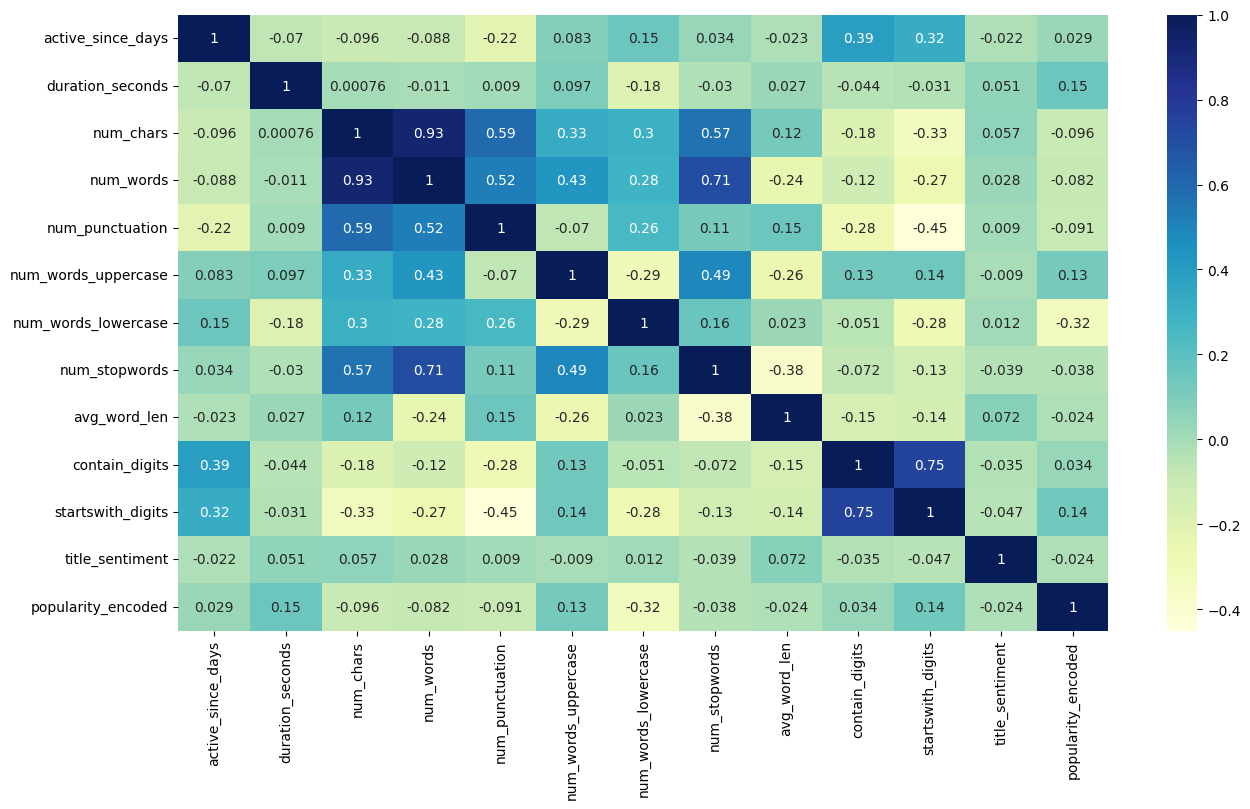

In [49]:
corr = five_minute_crafts.drop(['video_id', 'title'], axis=1).corr()

plt.figure(figsize=(15, 8))
sb.heatmap(corr, annot=True, cmap='YlGnBu')

Unlike the previous model, I did not want to include the 5 most used words in the titles in order to study the new approach from scratch. I started with the correlation, where I could see how this improved and already draw some first conclusions like, looking at the graph, at a glance, you could say that titles with a longer duration, titles starting with digits and a higher number of capitalized words tend to have a higher correlation with the popularity rank.

So, now that my problem was becoming a **multi-class ranking task**, so I used ranking models to train my data.

### Separate X and y. I train the models

In [50]:
X = five_minute_crafts.drop(['video_id','title','popularity_encoded'], axis=1)
y = five_minute_crafts['popularity_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [52]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Ridge Classifier": RidgeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Linear SVM": LinearSVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier()
}

In [53]:
# Logistic Regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_scaled, y_train)
y_pred_lr = logistic_regression.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_lr)

Logistic Regression Accuracy: 0.5261044176706827


/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
# Ridge Classifier
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train_scaled, y_train)
y_pred_rc = ridge_classifier.predict(X_test_scaled)
accuracy_rc = accuracy_score(y_test, y_pred_rc)
print("Ridge Classifier Accuracy:", accuracy_rc)


Ridge Classifier Accuracy: 0.5230923694779116


In [55]:
# Support Vector Machine
svm_classifier = SVC()
svm_classifier.fit(X_train_scaled, y_train)
y_pred_svm = svm_classifier.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Support Vector Machine Accuracy:", accuracy_svm)


Support Vector Machine Accuracy: 0.5491967871485943


In [56]:
# Linear SVM
linear_svm_classifier = LinearSVC()
linear_svm_classifier.fit(X_train_scaled, y_train)
y_pred_lsvm = linear_svm_classifier.predict(X_test_scaled)
accuracy_lsvm = accuracy_score(y_test, y_pred_lsvm)
print("Linear SVM Accuracy:", accuracy_lsvm)

/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Linear SVM Accuracy: 0.5240963855421686


/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [57]:
# Decision Tree
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train_scaled, y_train)
y_pred_dt = decision_tree_classifier.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)

Decision Tree Accuracy: 0.464859437751004


In [58]:
# Random Forest
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train_scaled, y_train)
y_pred_rf = random_forest_classifier.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.5180722891566265


In [59]:
# AdaBoost
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(X_train_scaled, y_train)
y_pred_ab = adaboost_classifier.predict(X_test_scaled)
accuracy_ab = accuracy_score(y_test, y_pred_ab)
print("AdaBoost Accuracy:", accuracy_ab)

AdaBoost Accuracy: 0.25903614457831325


/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [60]:
# Gradient Boosting
gradient_boosting_classifier = GradientBoostingClassifier()
gradient_boosting_classifier.fit(X_train_scaled, y_train)
y_pred_gb = gradient_boosting_classifier.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy:", accuracy_gb)

Gradient Boosting Accuracy: 0.5491967871485943


In [61]:
# XGBoost
xgboost_classifier = XGBClassifier()
xgboost_classifier.fit(X_train_scaled, y_train)
y_pred_xgb = xgboost_classifier.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)

XGBoost Accuracy: 0.5190763052208835


In [62]:
# CatBoost
catboost_classifier = CatBoostClassifier(verbose=False)
catboost_classifier.fit(X_train_scaled, y_train)
y_pred_catboost = catboost_classifier.predict(X_test_scaled)
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print("CatBoost Accuracy:", accuracy_catboost)

CatBoost Accuracy: 0.5371485943775101


The best result was obtained with the **Gradient Boosting model with a prediction result of 55.22 % (0.5532)**. This result already indicated a significant improvement over the previous model.

In this project it is multi-class classification with 5 categories, an accuracy of 20% (1 out of 5) would be equivalent to guessing at random. Therefore, any performance above this threshold is not only statistically significant, but also indicates the ability of the model to identify relevant patterns in the data.

I try to improve it:

#### Setting parameters using GridSearchCV

In [63]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

gb_model = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)


print("Best hyperparameters:", grid_search.best_params_)


Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


In [64]:
best_gb_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=200, random_state=42)
best_gb_model.fit(X_train_scaled, y_train)

y_pred_gb = best_gb_model.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy:", accuracy_gb)

Gradient Boosting Accuracy: 0.5612449799196787


- Before = 0.5532

- Now = **0.5612**.

There is a **small improvement after applying the GridSearchCV**.

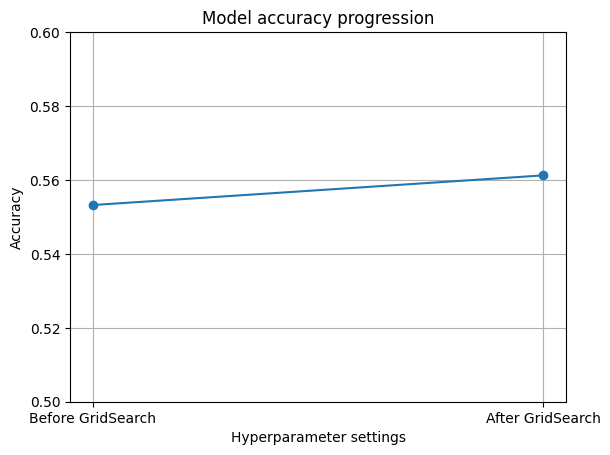

In [65]:
precisions = [0.5532128514056225, 0.5612449799196787]

labels = ['Before GridSearch', 'After GridSearch']

plt.plot(labels, precisions, marker='o', linestyle='-')
plt.ylim(0.5, 0.6)
plt.xlabel('Hyperparameter settings')
plt.ylabel('Accuracy')
plt.title('Model accuracy progression')
plt.grid(True)
plt.show()

#### Calculate model performance with cross validation

In [66]:
best_gb_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=200, random_state=42)

cv_scores = cross_val_score(best_gb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

mean_cv_score = cv_scores.mean()

print("Cross-validation scores:", cv_scores)
print("Average accuracy:", mean_cv_score)


Cross-validation scores: [0.56461731 0.57841907 0.56281407 0.57663317 0.5678392 ]
Average accuracy: 0.5700645637219977


Cross-validation is giving a more robust estimate of model accuracy.

As the improvement is insignificant, I will try to **improve the model by taking into account the popularity of the 5 most repeated words in the titles**:

In [67]:
five_minute_crafts = pd.read_csv('videos_classified.csv')

In [68]:
most_popular_words = ['hacks', 'life', 'ideas','DIY', 'crafts']

# Create a column
five_minute_crafts['most_popular_words'] = five_minute_crafts['title'].str.lower()

dummies = pd.get_dummies(five_minute_crafts['most_popular_words'].apply(lambda x: pd.Series([1 if palabra in x else 0 for palabra in most_popular_words], index=most_popular_words)))
five_minute_crafts = pd.concat([five_minute_crafts, dummies], axis=1)

# Remove the column 'most_popular_words'.
five_minute_crafts.drop('most_popular_words', axis=1, inplace=True)


five_minute_crafts.head()

,video_id,title,active_since_days,duration_seconds,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment,popularity_group,hacks,life,ideas,DIY,crafts
0,v=XHTofu5wbbM,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...,22,623,60,12,2,4,0,2,5.000000,0,0,0.144444,normal,1,1,0,0,0
1,v=HGxx0umIQvk,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...,1,739,87,17,4,5,0,3,5.117647,0,0,0.086905,normal,1,0,1,0,0
2,v=Tt4RMk3Ih04,HELPFUL LIFE HACKS FOR YOUR HOUSE,1,960,33,6,0,6,0,2,5.500000,0,0,0.000000,bad video,1,1,0,0,0
3,v=A2MTydM5e58,USEFUL HACKS FOR YOUR HOME || Simple Tips That...,30,833,66,12,2,5,0,3,5.500000,0,0,0.058333,good video,1,0,0,0,0
4,v=_halJ4yrmGQ,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...,15,3600,56,10,1,5,0,4,5.600000,0,0,0.500000,good video,1,0,0,0,1


In [69]:
custom_mapping = {'bad video': 1, 'good video': 3, 'normal': 2, 'super video': 4, 'very bad video': 0}

label_encoder = LabelEncoder()
label_encoder.fit(list(custom_mapping.keys()))

# Apply mapping and encode in numbers
five_minute_crafts['popularity_encoded'] = five_minute_crafts['popularity_group'].map(custom_mapping)

print(five_minute_crafts[['popularity_group', 'popularity_encoded']].head())

  popularity_group  popularity_encoded
0           normal                   2
1           normal                   2
2        bad video                   1
3       good video                   3
4       good video                   3


In [70]:
five_minute_crafts.drop('popularity_group', axis=1, inplace=True)

In [71]:
five_minute_crafts.to_csv('videos_classified_and_popular_words.csv', index=False)

In [72]:
five_minute_crafts = pd.read_csv('videos_classified_and_popular_words.csv')

In [73]:
five_minute_crafts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4978 entries, 0 to 4977
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   video_id             4978 non-null   object 
 1   title                4978 non-null   object 
 2   active_since_days    4978 non-null   int64  
 3   duration_seconds     4978 non-null   int64  
 4   num_chars            4978 non-null   int64  
 5   num_words            4978 non-null   int64  
 6   num_punctuation      4978 non-null   int64  
 7   num_words_uppercase  4978 non-null   int64  
 8   num_words_lowercase  4978 non-null   int64  
 9   num_stopwords        4978 non-null   int64  
 10  avg_word_len         4978 non-null   float64
 11  contain_digits       4978 non-null   int64  
 12  startswith_digits    4978 non-null   int64  
 13  title_sentiment      4978 non-null   float64
 14  hacks                4978 non-null   int64  
 15  life                 4978 non-null   i

<Axes: >

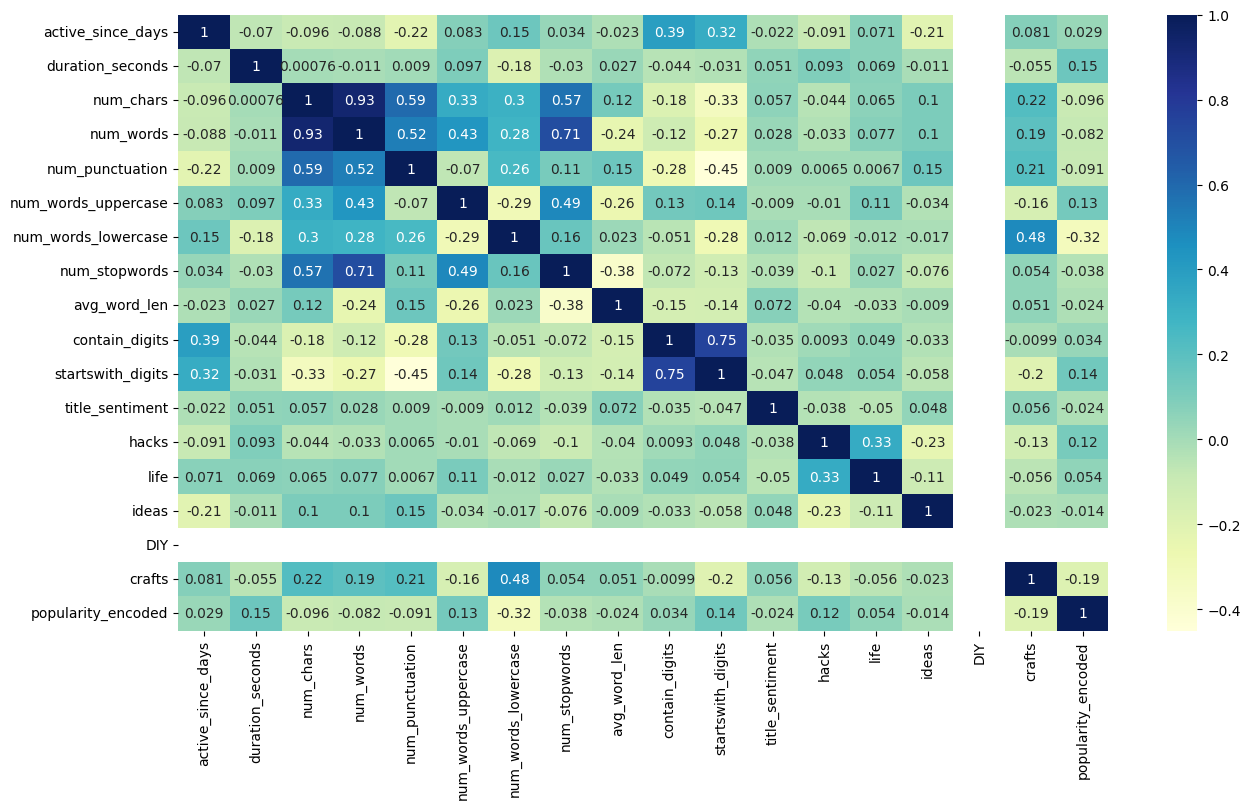

In [74]:
corr = five_minute_crafts.drop(['video_id', 'title'], axis=1).corr()

plt.figure(figsize=(15, 8))
sb.heatmap(corr, annot=True, cmap='YlGnBu')

In [75]:
X = five_minute_crafts.drop(['video_id','title','popularity_encoded'], axis=1)
y = five_minute_crafts['popularity_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
# Logistic Regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_scaled, y_train)
y_pred_lr = logistic_regression.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_lr)

Logistic Regression Accuracy: 0.5301204819277109


/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [78]:
# Ridge Classifier
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train_scaled, y_train)
y_pred_rc = ridge_classifier.predict(X_test_scaled)
accuracy_rc = accuracy_score(y_test, y_pred_rc)
print("Ridge Classifier Accuracy:", accuracy_rc)

Ridge Classifier Accuracy: 0.5271084337349398


In [79]:
# Support Vector Machine
svm_classifier = SVC()
svm_classifier.fit(X_train_scaled, y_train)
y_pred_svm = svm_classifier.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Support Vector Machine Accuracy:", accuracy_svm)

Support Vector Machine Accuracy: 0.5451807228915663


In [80]:
# Linear SVM
linear_svm_classifier = LinearSVC()
linear_svm_classifier.fit(X_train_scaled, y_train)
y_pred_lsvm = linear_svm_classifier.predict(X_test_scaled)
accuracy_lsvm = accuracy_score(y_test, y_pred_lsvm)
print("Linear SVM Accuracy:", accuracy_lsvm)

/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Linear SVM Accuracy: 0.5291164658634538


/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [81]:
# Decision Tree
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train_scaled, y_train)
y_pred_dt = decision_tree_classifier.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)

Decision Tree Accuracy: 0.44477911646586343


In [82]:
# Random Forest
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train_scaled, y_train)
y_pred_rf = random_forest_classifier.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.5120481927710844


In [83]:
# AdaBoost
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(X_train_scaled, y_train)
y_pred_ab = adaboost_classifier.predict(X_test_scaled)
accuracy_ab = accuracy_score(y_test, y_pred_ab)
print("AdaBoost Accuracy:", accuracy_ab)

AdaBoost Accuracy: 0.25903614457831325


/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [84]:
# Gradient Boosting
gradient_boosting_classifier = GradientBoostingClassifier()
gradient_boosting_classifier.fit(X_train_scaled, y_train)
y_pred_gb = gradient_boosting_classifier.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy:", accuracy_gb)

Gradient Boosting Accuracy: 0.5421686746987951


In [85]:
# XGBoost
xgboost_classifier = XGBClassifier()
xgboost_classifier.fit(X_train_scaled, y_train)
y_pred_xgb = xgboost_classifier.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)

XGBoost Accuracy: 0.5100401606425703


In [86]:
# CatBoost
catboost_classifier = CatBoostClassifier(verbose=False)
catboost_classifier.fit(X_train_scaled, y_train)
y_pred_catboost = catboost_classifier.predict(X_test_scaled)
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print("CatBoost Accuracy:", accuracy_catboost)

CatBoost Accuracy: 0.5291164658634538


My best result is still **Gradient Boosting (accuracy: 0.5481)**. But, it gets worse when taking into account the most repeated words in the titles. So, I am going to check **which are the most relevant variables of my model and train it only with these** and see if I can improve it.


In [87]:
# Obtain the importance of the characteristics 
importancia_caracteristicas = gradient_boosting_classifier.feature_importances_

# Obtain the indexes of the most important characteristics
indices_top5 = np.argsort(importancia_caracteristicas)[::-1][:5]

# Obtain the names of the most important features
nombres_top5 = X.columns[indices_top5]

# Print the names of the most relevant characteristics
print("Las cinco características más relevantes para el modelo Gradient Boosting son:")
print(nombres_top5)


Las cinco características más relevantes para el modelo Gradient Boosting son:
Index(['duration_seconds', 'active_since_days', 'num_chars', 'avg_word_len',
       'title_sentiment'],
      dtype='object')


This is the ranking of the 5 most relevant variables for the models:
- duration_seconds
- active_since_days
- avg_word_len
- num_chars
- title_sentiment

To see if my models improve, I'm just going to stick with these variables for training:

In [88]:
five_minute_crafts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4978 entries, 0 to 4977
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   video_id             4978 non-null   object 
 1   title                4978 non-null   object 
 2   active_since_days    4978 non-null   int64  
 3   duration_seconds     4978 non-null   int64  
 4   num_chars            4978 non-null   int64  
 5   num_words            4978 non-null   int64  
 6   num_punctuation      4978 non-null   int64  
 7   num_words_uppercase  4978 non-null   int64  
 8   num_words_lowercase  4978 non-null   int64  
 9   num_stopwords        4978 non-null   int64  
 10  avg_word_len         4978 non-null   float64
 11  contain_digits       4978 non-null   int64  
 12  startswith_digits    4978 non-null   int64  
 13  title_sentiment      4978 non-null   float64
 14  hacks                4978 non-null   int64  
 15  life                 4978 non-null   i

In [89]:
X = five_minute_crafts.drop(['video_id','title','popularity_encoded','num_words','num_punctuation','num_words_uppercase',
                             'num_words_lowercase','num_stopwords','contain_digits','startswith_digits','hacks','life',
                             'ideas','DIY','crafts'], axis=1)
y = five_minute_crafts['popularity_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [91]:
# Gradient Boosting
gradient_boosting_classifier = GradientBoostingClassifier()
gradient_boosting_classifier.fit(X_train_scaled, y_train)
y_pred_gb = gradient_boosting_classifier.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy:", accuracy_gb)

Gradient Boosting Accuracy: 0.5622489959839357


Using the most important variables, the model improves:

* Before: Accuracy of 0.5481
* Now: **Accuracy of 0.5622**.

By training it only with these variables it improves, but I will try to refine it further:

In [92]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

gb_model = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)


print("Better hyperparameters:", grid_search.best_params_)

Better hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


In [93]:
best_gb_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=200, random_state=42)
best_gb_model.fit(X_train_scaled, y_train)

y_pred_gb = best_gb_model.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy:", accuracy_gb)

Gradient Boosting Accuracy: 0.5642570281124498


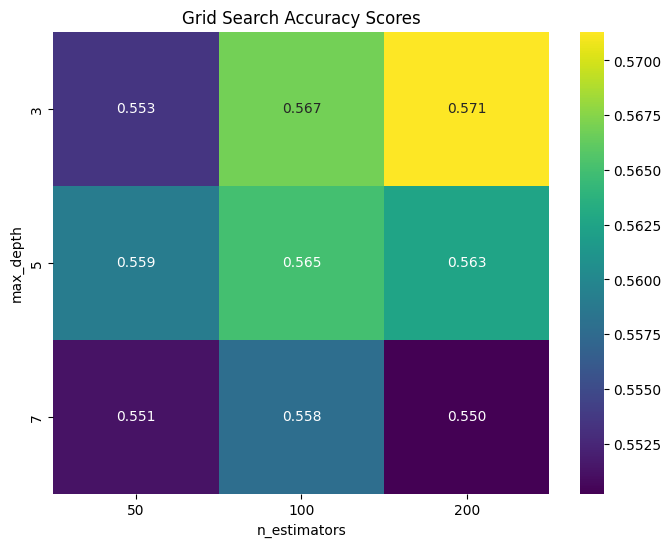

In [94]:
# Get the results of the grid search
cv_results = grid_search.cv_results_

# Find the number of different values for 'n_estimators' and 'max_depth'.
n_estimators_range = param_grid['n_estimators']
max_depth_range = param_grid['max_depth']
learning_rate_range = param_grid['learning_rate']

# create the matrix of accuracy scores for each combination of 'n_estimators' and 'max_depth'.
# 'learning_rate' will be set to the best found value
scores_matrix = np.array([
    cv_results['mean_test_score'][
        (cv_results['param_learning_rate'] == grid_search.best_params_['learning_rate']) &
        (cv_results['param_n_estimators'] == n_estimator) &
        (cv_results['param_max_depth'] == max_depth)
    ]
    for max_depth in max_depth_range
    for n_estimator in n_estimators_range
]).reshape(len(max_depth_range), len(n_estimators_range))

plt.figure(figsize=(8, 6))
sns.heatmap(scores_matrix, annot=True, fmt=".3f", xticklabels=n_estimators_range, yticklabels=max_depth_range, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.title('Grid Search Accuracy Scores')
plt.show()


In [95]:
best_gb_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=200, random_state=42)

cv_scores = cross_val_score(best_gb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

mean_cv_score = cv_scores.mean()

print("Cross-validation scores:", cv_scores)
print("Average accuracy:", mean_cv_score)

Cross-validation scores: [0.56963614 0.57590966 0.5678392  0.57160804 0.57160804]
Average accuracy: 0.5713202146239353


It improves, but still very little. So I am going to see if it improves with **unsupervised models**. Since I don't have many columns, I won't use PCA, I will do clustering with **k-means** to group the data into groups with similar characteristics.

In [96]:
features_important = ['duration_seconds','active_since_days','avg_word_len',
'num_chars','title_sentiment']


features = five_minute_crafts[features_important]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

five_minute_crafts['cluster'] = clusters


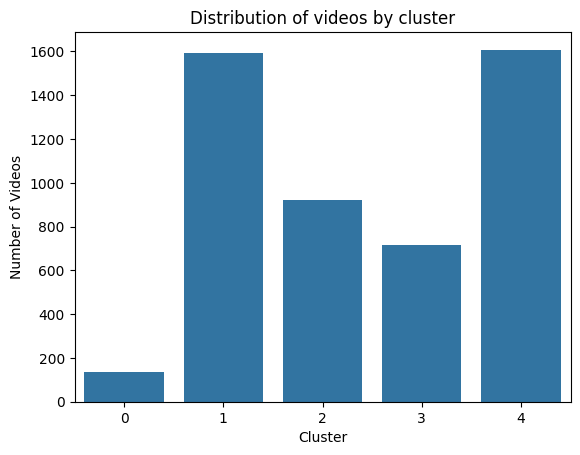

In [97]:
sns.countplot(x='cluster', data=five_minute_crafts)
plt.title('Distribution of videos by cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Videos')
plt.show()


In [98]:
for i in range(kmeans.n_clusters):
    print(f"\nAverage Cluster Characteristics {i}:")
    cluster_means = five_minute_crafts[five_minute_crafts['cluster'] == i][features_important].mean()
    print(cluster_means)



Average Cluster Characteristics 0:
duration_seconds     4323.913043
active_since_days     618.688406
avg_word_len            5.600651
num_chars              49.072464
title_sentiment         0.399223
dtype: float64

Average Cluster Characteristics 1:
duration_seconds     854.612680
active_since_days    670.096045
avg_word_len           5.093765
num_chars             35.534212
title_sentiment        0.041481
dtype: float64

Average Cluster Characteristics 2:
duration_seconds     817.895879
active_since_days    384.803688
avg_word_len           5.463904
num_chars             59.381779
title_sentiment        0.352464
dtype: float64

Average Cluster Characteristics 3:
duration_seconds     839.888424
active_since_days    779.610879
avg_word_len           6.503109
num_chars             38.937238
title_sentiment        0.363746
dtype: float64

Average Cluster Characteristics 4:
duration_seconds      825.371269
active_since_days    1277.500000
avg_word_len            5.355098
num_chars       

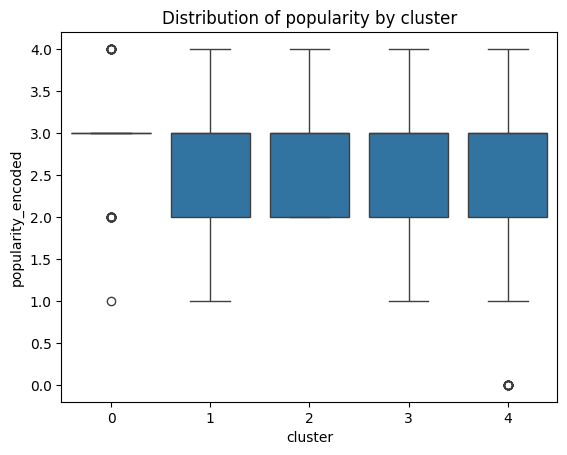


Average Cluster Popularity 0:
2.9130434782608696

Average Cluster Popularity 1:
2.7043314500941618

Average Cluster Popularity 2:
2.58351409978308

Average Cluster Popularity 3:
2.7475592747559276

Average Cluster Popularity 4:
2.6237562189054726


In [99]:
# How popularity is distributed in each cluster
sns.boxplot(x='cluster', y='popularity_encoded', data=five_minute_crafts)
plt.title('Distribution of popularity by cluster')
plt.show()

# Average popularity per cluster
for i in range(kmeans.n_clusters):
    print(f"\nAverage Cluster Popularity {i}:")
    popularity_mean = five_minute_crafts[five_minute_crafts['cluster'] == i]['popularity_encoded'].mean()
    print(popularity_mean)


Now that I have information from the different clusters, I will include them as a new feature in my dataset and retrain the model (only using the most important variables):

In [100]:
features = ['duration_seconds', 'active_since_days', 'avg_word_len', 'num_chars', 'title_sentiment', 'cluster']

X = five_minute_crafts[features]
y = five_minute_crafts['popularity_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

best_gb_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=200, random_state=42)
best_gb_model.fit(X_train_scaled, y_train)

y_pred_gb = best_gb_model.predict(X_test_scaled)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy:", accuracy_gb)

Gradient Boosting Accuracy: 0.5642570281124498


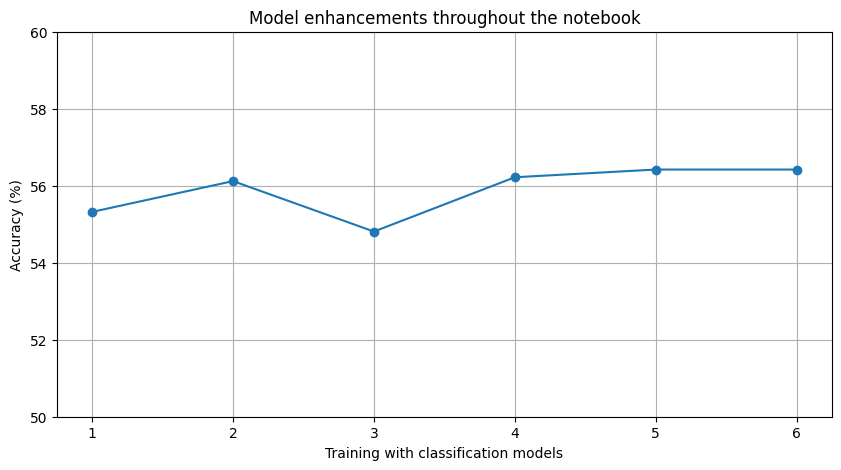

In [101]:
# Iterations
iteration_list = [1, 2, 3, 4, 5,6]

accuracy_list = [55.32, 56.12, 54.81, 56.22, 56.42, 56.42]

plt.figure(figsize=(10, 5))
plt.plot(iteration_list, accuracy_list, marker='o', linestyle='-')
plt.title('Model enhancements throughout the notebook')
plt.xlabel('Training with classification models')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.xticks(iteration_list)
plt.ylim([50, 60])
plt.show()


During all the training I had always done using classification models, they gave me a very similar if not identical result.

Therefore, it was necessary to go a step further and start using a variable that I had not used so far: the titles of the videos through NLP tools:

----

# Improving the model using Natural Language Processing (NLP)

In [102]:
five_minute_crafts = pd.read_csv('/Users/lunaflorestorres/Desktop/PREDICCION-DE-LA-POPULARIDAD-DE-LOS-VIDEOS-DE-5-MINUTE-CRAFTS/src/data/processed/videos_classified_and_popular_words.csv')

In [103]:
five_minute_crafts.head()

,video_id,title,active_since_days,duration_seconds,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment,hacks,life,ideas,DIY,crafts,popularity_encoded
0,v=XHTofu5wbbM,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...,22,623,60,12,2,4,0,2,5.000000,0,0,0.144444,1,1,0,0,0,2
1,v=HGxx0umIQvk,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...,1,739,87,17,4,5,0,3,5.117647,0,0,0.086905,1,0,1,0,0,2
2,v=Tt4RMk3Ih04,HELPFUL LIFE HACKS FOR YOUR HOUSE,1,960,33,6,0,6,0,2,5.500000,0,0,0.000000,1,1,0,0,0,1
3,v=A2MTydM5e58,USEFUL HACKS FOR YOUR HOME || Simple Tips That...,30,833,66,12,2,5,0,3,5.500000,0,0,0.058333,1,0,0,0,0,3
4,v=_halJ4yrmGQ,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...,15,3600,56,10,1,5,0,4,5.600000,0,0,0.500000,1,0,0,0,1,3


### Convert titles, which are text strings, into a form that the network can understand: numbers (tokenization)

In [104]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(five_minute_crafts['title'])
sequences = tokenizer.texts_to_sequences(five_minute_crafts['title'])
print("Original title:", five_minute_crafts['title'].iloc[0])
print("Tokenized title:", sequences[0])

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1
vocab_size

Original title: SUPER LAZY LIFE HACKS || Cool Hacks To Make Your Life Easier
Tokenized title: [182, 196, 6, 1, 18, 1, 2, 12, 5, 6, 65]


2147

In [105]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [106]:
with open('sequences.pickle', 'wb') as handle:
    pickle.dump(sequences, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Apply Padding to Sequences

In [107]:
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
print("Shape of sequences with padding:", padded_sequences.shape)

Shape of sequences with padding: (4978, 19)


In [108]:
labels = to_categorical(five_minute_crafts['popularity_encoded'])
num_classes = labels.shape[1]
num_classes

5

The first thing I had to do was to tokenize the videos so that they could be understood by the neural network I was going to create. That is, I had to convert them to numbers.

Then, I calculated the maximum length of all the word sequences in the titles, and then filled the shorter word sequences with zeros so that they would all have the same length and the same dimension.

And my target variable, which was the video classification group, I also transformed it even though it was already numerical, using one hot encoder so that class was represented in a unique way and without any ordinal relationship that could confuse the neural network.

### Build neural network

In [109]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_shape=(max_length,)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(num_classes, activation='softmax')  # Adjustment for multi-class classification
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 19, 50)         │       107,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 950)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         9,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,915 (456.70 KB)

 Trainable params: 116,915 (456.70 KB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [110]:
train = model.fit(padded_sequences, labels,
                    epochs=20, 
                    batch_size=32, 
                    validation_split=0.2) 

Epoch 1/20


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4516 - loss: 1.4055 - val_accuracy: 0.4076 - val_loss: 1.4299
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5048 - loss: 0.9918 - val_accuracy: 0.4227 - val_loss: 1.6008
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5265 - loss: 0.9251 - val_accuracy: 0.4217 - val_loss: 1.6344
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5989 - loss: 0.8749 - val_accuracy: 0.4147 - val_loss: 1.6943
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6749 - loss: 0.8131 - val_accuracy: 0.4257 - val_loss: 1.7715
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7172 - loss: 0.7256 - val_accuracy: 0.4257 - val_loss: 1.8914
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7512 - loss: 0.6427 - val_accuracy: 0.4267 - val_loss: 1.9412
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7649 - loss: 0.5840 - val_accuracy: 0.4116 - val_

### Evaluate the model

In [111]:
test_loss, test_accuracy = model.evaluate(padded_sequences, labels, verbose=1)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

 46/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9525 - loss: 0.1492 

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.9150 - loss: 0.2518
Test Loss: 0.7440663576126099, Test Accuracy: 0.80815589427948


In [112]:
seq = tokenizer.texts_to_sequences('SUPER LAZY LIFE HACKS || Cool Hacks To Make Your Life Easier')
    # Print the generated numerical sequence to verify the conversion.
print("Numerical sequence:", seq)
padded_seq = pad_sequences(seq, maxlen=max_length, padding='post')
prediction = model.predict(padded_sequences)
prediction_label = np.argmax(prediction, axis=1)

    # Define your categories correctly.
categories = ['very bad video', 'bad video', 'normal', 'good video', 'supervideo']
predicted_category = categories[prediction_label[0]]
print(predicted_category)

Numerical sequence: [[], [], [], [], [], [], [52], [25], [], [], [], [52], [783], [], [], [], [], [25], [], [], [], [], [], [], [], [], [], [], [52], [], [], [25], [], [], [], [], [389], [], [], [], [25], [], [], [], [], [], [], [], [], [52], [783], [], [], [], [], [25], [], [783], [], []]
  1/156 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
normal


In [113]:
# Generate predictions
predictions = model.predict(padded_sequences)
# Convert one-hot predictions to tags
predicted_labels = np.argmax(predictions, axis=1)
# Convert true one-hot tags to tags
true_labels = np.argmax(labels, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
conf_matrix

# Calculate the ranking report
class_report = classification_report(true_labels, predicted_labels)
print('Informe de Clasificación:\n', class_report)

 58/156 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
Informe de Clasificación:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00       114
           2       0.77      0.87      0.81      1893
           3       0.85      0.85      0.85      2439
           4       0.79      0.61      0.69       516

    accuracy                           0.81      4978
   macro avg       0.48      0.47      0.47      4978
weighted avg       0.79      0.81      0.80      4978



/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [114]:
five_minute_crafts['popularity_encoded'].value_counts()

popularity_encoded
3    2439
2    1893
4     516
1     114
0      16
Name: count, dtype: int64

In summary, create a neural network to solve a text classification problem, using different layers:
* The Embedding layer converts words into numeric vectors, such that similar words have similar vectors.
* The Flatten layer flattens these vectors into a single dimension.
* The Dense layer takes the flattened word vectors and processes them to find patterns and features.
* And finally, the Dense output layer takes all the processed information and uses it to predict the class to which a given text belongs. In this case, there are 5 possible classes to predict.

After defining what the neural network looks like, it is built using the compile() function, which basically configures how the neural network learns from the data. In this case, I have used a technique called "Adam's optimization" to learn from the data and "categorical cross-entropy" as a way to measure how good the model's predictions are.

Once the network was created, I trained the model with the titles. How did I do that? I showed it my data 20 times to learn. But, instead of showing it all the data at once, I did it in groups of 32 examples to make the training faster. And of course, I reserved 20% of the data for validation.

After training, I evaluated the network with the reserved data, and I obtained an accuracy of 81.62% and a loss of 0.73. Obviously, by using natural language processing tools, my model has improved infinitely.


Conclusions after training my data using NLP:

* **Accuracy improves significantly (0.92)**.

* Class imbalance**: classes 0 (16 cases) and 1 (114 cases) have much less representation in the data set than classes 2 (1893 cases), 3 (2439 cases), and 4 (516 cases). This imbalance may make the model less effective in correctly identifying underrepresented classes.

* **Low performance on minority classes**: classes 0 and 1 have an accuracy and recall of 0.00, indicating that the model was unable to correctly identify any instances of these classes. This is probably a consequence of the class imbalance mentioned above.

* **Good performance on majority classes**: classes 2, 3, and 4 have relatively high precision, recall, and F1-score, suggesting that the model is effective in identifying these classes. 

The weighted precision and weighted F1-score are both around **0.80, indicating good overall model performance**. However, **performance on minority classes is dismal**. To fix this, I will **group the class 0 and 1 data into one ('bad video')** and retrain the model:

### Unify group 0 and 1 as they have very few data

In [115]:
# Unify groups 0 and 1 into one group (0)
five_minute_crafts['popularity_encoded'] = five_minute_crafts['popularity_encoded'].replace({1: 0})

print(five_minute_crafts['popularity_encoded'].value_counts().sort_index())


popularity_encoded
0     130
2    1893
3    2439
4     516
Name: count, dtype: int64


### Adjust the rest of the groups

In [116]:
five_minute_crafts.to_csv('clasificacion_de_cuatro_grupos.csv', index=False)
five_minute_crafts = pd.read_csv('/Users/lunaflorestorres/Desktop/PREDICCION-DE-LA-POPULARIDAD-DE-LOS-VIDEOS-DE-5-MINUTE-CRAFTS/src/notebooks/clasificacion_de_cuatro_grupos.csv')
five_minute_crafts['popularity_encoded'].unique()

array([2, 0, 3, 4])

In [117]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(five_minute_crafts['title'])
sequences = tokenizer.texts_to_sequences(five_minute_crafts['title'])
print("Original title:", five_minute_crafts['title'].iloc[0])
print("Tokenized title:", sequences[0])

vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
print(vocab_size)
print(max_length)
print(padded_sequences)

Original title: SUPER LAZY LIFE HACKS || Cool Hacks To Make Your Life Easier
Tokenized title: [182, 196, 6, 1, 18, 1, 2, 12, 5, 6, 65]
2147
19
[[182 196   6 ...   0   0   0]
 [864  16  44 ...   0   0   0]
 [382   6   1 ...   0   0   0]
 ...
 [ 59   2 308 ...   0   0   0]
 [254  11   2 ...   0   0   0]
 [ 22 631  14 ...   0   0   0]]


In [118]:
# Adjust the popularity_encoded values
five_minute_crafts['popularity_encoded'] = five_minute_crafts['popularity_encoded'].replace({2: 1, 3: 2, 4: 3})

In [119]:
print(five_minute_crafts['popularity_encoded'].unique())


[1 0 2 3]


In [120]:
# Check that I have 4 classes and not 5 as before

labels = to_categorical(five_minute_crafts['popularity_encoded'], num_classes=4)
num_classes = labels.shape[1]
num_classes

4

In [121]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_shape=(max_length,)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(num_classes, activation='softmax')  # Adjustment for multi-class classification
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 19, 50)         │       107,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 950)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         9,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,904 (456.66 KB)

 Trainable params: 116,904 (456.66 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
model.fit(padded_sequences, labels, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
  1/125 ━━━━━━━━━━━━━━━━━━━━ 2:17 1s/step - accuracy: 0.1562 - loss: 1.3996

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4834 - loss: 1.1264 - val_accuracy: 0.4076 - val_loss: 1.4028
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5521 - loss: 0.9101 - val_accuracy: 0.4729 - val_loss: 1.4814
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6338 - loss: 0.8656 - val_accuracy: 0.4809 - val_loss: 1.5553
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6916 - loss: 0.7584 - val_accuracy: 0.4799 - val_loss: 1.6330
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7430 - loss: 0.6823 - val_accuracy: 0.4568 - val_loss: 1.7683
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7706 - loss: 0.5834 - val_accuracy: 0.4608 - val_loss: 1.8279
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7835 - loss: 0.5273 - val_accuracy: 0.4367 - val_loss: 1.9112
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8040 - loss: 0.4800 - val_accuracy: 0.4408 - val_

In [123]:
test_loss, test_accuracy = model.evaluate(padded_sequences, labels, verbose=1)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

 64/156 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.9604 - loss: 0.1347

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.9285 - loss: 0.2279
Test Loss: 0.7412459254264832, Test Accuracy: 0.8210124373435974


In [124]:
# Generation of a classification report
predictions = model.predict(padded_sequences)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(labels, axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
conf_matrix

class_report = classification_report(true_labels, predicted_labels)
print('Classification Report:\n', class_report)

  1/156 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       130
           1       0.79      0.87      0.83      1893
           2       0.84      0.87      0.86      2439
           3       0.83      0.61      0.70       516

    accuracy                           0.82      4978
   macro avg       0.62      0.59      0.60      4978
weighted avg       0.80      0.82      0.81      4978



/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Class 0, **'bad video', is still lousy**. That's why I'm going to do an **oversampling on the minority class**:

In [125]:
five_minute_crafts['popularity_encoded'] = five_minute_crafts['popularity_encoded'].replace({1: 0, 2: 1, 3: 2})

print(five_minute_crafts['popularity_encoded'].value_counts().sort_index())

popularity_encoded
0    2023
1    2439
2     516
Name: count, dtype: int64


In [126]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(five_minute_crafts['title'])
sequences = tokenizer.texts_to_sequences(five_minute_crafts['title'])

vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

labels = to_categorical(five_minute_crafts['popularity_encoded'], num_classes=3)

In [127]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_shape=(max_length,)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(3, activation='softmax') 
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 19, 50)         │       107,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 950)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         9,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,893 (456.61 KB)

 Trainable params: 116,893 (456.61 KB)

 Non-trainable params: 0 (0.00 B)

In [128]:
model.fit(padded_sequences, labels, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5117 - loss: 0.9800 - val_accuracy: 0.4076 - val_loss: 0.9864
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5209 - loss: 0.9189 - val_accuracy: 0.4317 - val_loss: 0.9771
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6029 - loss: 0.8543 - val_accuracy: 0.4689 - val_loss: 1.0020
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7070 - loss: 0.7349 - val_accuracy: 0.4779 - val_loss: 1.0600
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7650 - loss: 0.5869 - val_accuracy: 0.4950 - val_loss: 1.1755
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7906 - loss: 0.5219 - val_accuracy: 0.4809 - val_loss: 1.2542
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8295 - loss: 0.4401 - val_accuracy: 0.4890 - val_loss: 1.3060
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8396 - loss: 0.4059 - val_accuracy: 0.4829 - val_

In [129]:
test_loss, test_accuracy = model.evaluate(padded_sequences, labels, verbose=1)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

 60/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9596 - loss: 0.1086

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9234 - loss: 0.2152
Test Loss: 0.6183044910430908, Test Accuracy: 0.8276416063308716


In [130]:
# Generate and evaluate predictions with the new classification configuration
predictions = model.predict(padded_sequences)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(labels, axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:\n', conf_matrix)

class_report = classification_report(true_labels, predicted_labels)
print('Classification Report:\n', class_report)

 31/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix:
 [[1762  210   51]
 [ 376 1985   78]
 [  73   70  373]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83      2023
           1       0.88      0.81      0.84      2439
           2       0.74      0.72      0.73       516

    accuracy                           0.83      4978
   macro avg       0.81      0.80      0.80      4978
weighted avg       0.83      0.83      0.83      4978



As can be seen, **improves the accuracy (0.9301) and decreases the loss**. It also improves the classification of all groups, solving the problem with group 0.

In [131]:
### Checking that the search for examples of my 3 groups is still working

def print_example_by_group(five_minute_crafts):
    categorias = {
        0: "Bad Video",
        1: "Normal",
        2: "Super Videoo",
    }
    
    for codigo, etiqueta in categorias.items():
        # Find a sample title for each category
        ejemplo_titulo = five_minute_crafts[five_minute_crafts['popularity_encoded'] == codigo]['title'].iloc[33]
        print(f"Range: {etiqueta} - Title: {ejemplo_titulo}")

print_example_by_group(five_minute_crafts)

Range: Bad Video - Title: HOW TO HIDE CANDIES FROM YOUR KIDS 🍬 Priceless Hacks For Smart Parents
Range: Normal - Title: BEST PET GADGETS AND HACKS EVERY PET OWNER SHOULD KNOW
Range: Super Videoo - Title: CLEVER CAMPING IDEAS For a Perfect Time Outdoors! #shorts


The **accuracy (0.6627)** decreases, but the data is better balanced between groups and the model predicts better.

In [132]:
model.save('/Users/lunaflorestorres/Desktop/PREDICCION-DE-LA-POPULARIDAD-DE-LOS-VIDEOS-DE-5-MINUTE-CRAFTS/src/model/my_model.h5')